In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Importação bibliotecas

In [2]:
!pip install rasterio

     |████████████████████████████████| 19.3 MB 13.9 MB/s 


In [3]:
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from os.path import isfile

import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist

%matplotlib inline

###Image raster plot

In [4]:
def plot_raster(image):
  fig, (axr, axg, axb) = plt.subplots(1,3, figsize=(21,7))
  show((image, 1), ax=axr, cmap='Reds', title='red channel')
  show((image, 2), ax=axg, cmap='Greens', title='green channel')
  show((image, 3), ax=axb, cmap='Blues', title='blue channel')
  plt.show()

In [5]:
def media_cores(image):
  return image.read().mean()

In [6]:
def plot_histograma(image):
  print('média das cores: ' + str(media_cores(image)))
  show_hist(image, bins=50, lw=0.0, stacked=False, alpha=0.3,histtype='stepfilled', title="Histogram")

In [7]:
def print_infos(image):
  # How many bands does this image have?
  num_bands = image.count
  print('Number of bands in image: {n}\n'.format(n=num_bands))

  # How many rows and columns?
  rows, cols = image.shape
  print('Image size is: {r} rows x {c} columns\n'.format(r=rows, c=cols))

  # What driver was used to open the raster?
  driver = image.driver
  print('Raster driver: {d}\n'.format(d=driver))

  # What is the raster's projection?
  proj = image.crs
  print('Image projection:')
  print(proj)

Imagem analisada
média das cores: 638.7612466124662


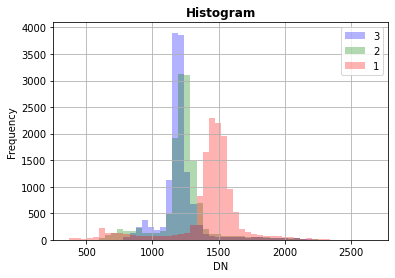

Imagem referência
média das cores: 625.3748090662725


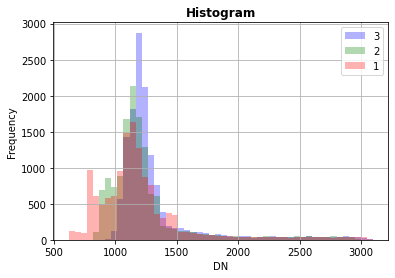

In [24]:
print("Imagem analisada")
image_raster = rasterio.open('drive/MyDrive/BEMAGRO/dataset_1/RGB/2021-02-22.tif')
plot_histograma(image_raster)

print("Imagem referência")
image_raster = rasterio.open('drive/MyDrive/BEMAGRO/dataset_1/RGB/2017-02-23.tif')
plot_histograma(image_raster)

red 706.8617886178862
green 609.3345158906135
blue 600.0874353288988
full 638.7612466124662


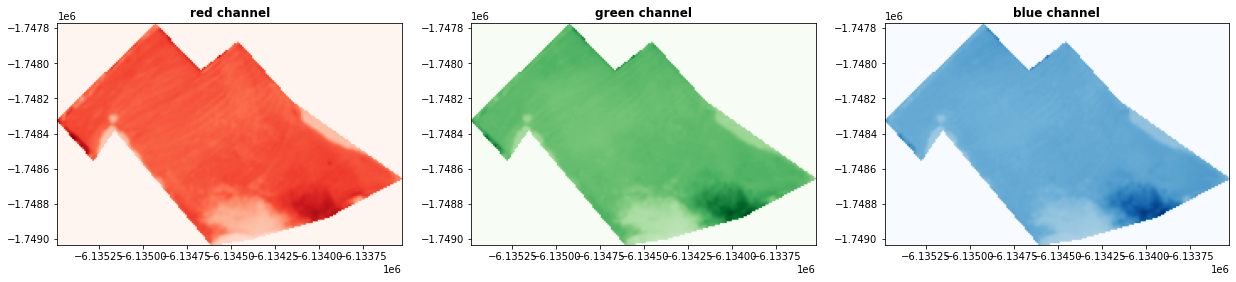

In [9]:
image_raster = rasterio.open('drive/MyDrive/BEMAGRO/dataset_1/RGB/2021-02-22.tif')
print('red', image_raster.read(1).mean())
print('green', image_raster.read(2).mean())
print('blue', image_raster.read(3).mean())
print('full', image_raster.read().mean())
plot_raster(image_raster)

###Manipulando dataset

In [10]:
df1 = pd.read_csv('drive/MyDrive/BEMAGRO/dataset_1/DATASET1.csv')
df2 = pd.read_csv('drive/MyDrive/BEMAGRO/dataset_2/DATASET2.csv')

In [11]:
def create_features(df, anobase, num_dataset):
  media_cor = []
  media_cor_esperada = []
  diff_media_cor = []
  status = []
  cultura = []

  for index, row in df.iterrows():
    row_media_cor = 0
    row_media_cor_esperada = 0

    #Media das cores
    caminho_imagem = 'drive/MyDrive/BEMAGRO/dataset_' + num_dataset + '/' + row['RGB']
    if isfile(caminho_imagem):
      image_raster = rasterio.open(caminho_imagem)
      row_media_cor = media_cores(image_raster)
    
    media_cor.append(row_media_cor)

    #Média cor esperada
    dff = df[(df['temp ano'] == anobase) & (df['temp mes'] == row['temp mes'])]

    if len(np.array(dff['RGB'])) > 0:
      caminho_imagem = 'drive/MyDrive/BEMAGRO/dataset_' + num_dataset + '/' + dff['RGB'].values[0]
      if isfile(caminho_imagem):
        image_raster = rasterio.open(caminho_imagem)
        row_media_cor_esperada = media_cores(image_raster)
      else:
        row_media_cor_esperada = row_media_cor
    else:
      row_media_cor_esperada = row_media_cor

    media_cor_esperada.append(row_media_cor_esperada)

    #Diferença cores
    diff_cor = row_media_cor - row_media_cor_esperada
    diff_media_cor.append(diff_cor)

    if(diff_cor > 50):
      status.append(1)#adiantada
    elif(diff_cor < -50):
      status.append(2)#atradada
    else:
      status.append(3)#normal

    if(row['Cultura'] == 'algodao'):
      cultura.append(1)
    elif(row['Cultura'] == 'soja'):
      cultura.append(2)
    else:
      cultura.append(3)#colheita
  
  df["media_cor"] = media_cor
  df["media_cor_esperada"] = media_cor_esperada
  df["diff_cor_esperada"] = diff_media_cor
  df["status"] = status
  df["Cultura"] = cultura

  df = df[['Nublado', 'Cultura', 'media_cor', 'media_cor_esperada', 'status']]
  df['Nublado'] = df['Nublado'].apply(lambda x: 1 if float(x.replace("%", "").replace(",", ".")) > 0 else 0)

  return df

In [12]:
def split_features(df):
  X = df[['Nublado', 'Cultura', 'media_cor', 'media_cor_esperada']]
  y = df['status']

  return X, y

In [13]:
df1 = create_features(df1, 2017, '1')
df2 = create_features(df2, 2018, '2')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


###Separação Treino e Teste

In [14]:
X, y = split_features(df1)
#X, y = split_features(df2)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

###Modelos

####Arvore de decisão

In [16]:
model = DecisionTreeClassifier(criterion="entropy", max_depth=5)
model.fit(X_train, y_train)

y_predict = model.predict(X_test)
print(classification_report(y_test, y_predict))
print('Acurácia no treino: %.2f' % model.score(X_train, y_train))
print('Acurácia no teste: %.2f' % model.score(X_test, y_test))

              precision    recall  f1-score   support

           1       0.60      0.60      0.60         5
           2       1.00      0.67      0.80         6
           3       0.64      0.78      0.70         9

    accuracy                           0.70        20
   macro avg       0.75      0.68      0.70        20
weighted avg       0.74      0.70      0.71        20

Acurácia no treino: 0.98
Acurácia no teste: 0.70


####Random forest

In [17]:
model = RandomForestClassifier(criterion="entropy", max_depth=5, n_estimators=10)
model.fit(X_train, y_train)

y_predict = model.predict(X_test)
print(classification_report(y_test, y_predict))
print('Acurácia no treino: %.2f' % model.score(X_train, y_train))
print('Acurácia no teste: %.2f' % model.score(X_test, y_test))

              precision    recall  f1-score   support

           1       0.60      0.60      0.60         5
           2       1.00      0.33      0.50         6
           3       0.54      0.78      0.64         9

    accuracy                           0.60        20
   macro avg       0.71      0.57      0.58        20
weighted avg       0.69      0.60      0.59        20

Acurácia no treino: 0.98
Acurácia no teste: 0.60


####Naive Bayes

In [18]:
model = GaussianNB()
model.fit(X_train, y_train)

y_predict = model.predict(X_test)
print(classification_report(y_test, y_predict))
print('Acurácia no treino: %.2f' % model.score(X_train, y_train))
print('Acurácia no teste: %.2f' % model.score(X_test, y_test))

              precision    recall  f1-score   support

           1       0.50      0.40      0.44         5
           2       1.00      0.33      0.50         6
           3       0.50      0.78      0.61         9

    accuracy                           0.55        20
   macro avg       0.67      0.50      0.52        20
weighted avg       0.65      0.55      0.54        20

Acurácia no treino: 0.76
Acurácia no teste: 0.55


####SVM

In [19]:
model = SVC(C=100, kernel='linear')
model.fit(X_train, y_train)

y_predict = model.predict(X_test)
print(classification_report(y_test, y_predict))
print('Acurácia no treino: %.2f' % model.score(X_train, y_train))
print('Acurácia no teste: %.2f' % model.score(X_test, y_test))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         5
           2       1.00      0.67      0.80         6
           3       0.82      1.00      0.90         9

    accuracy                           0.90        20
   macro avg       0.94      0.89      0.90        20
weighted avg       0.92      0.90      0.89        20

Acurácia no treino: 1.00
Acurácia no teste: 0.90


####Gradient Boosting

In [20]:
model = GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=10)
model.fit(X_train, y_train)

y_predict = model.predict(X_test)
print(classification_report(y_test, y_predict))
print('Acurácia no treino: %.2f' % model.score(X_train, y_train))
print('Acurácia no teste: %.2f' % model.score(X_test, y_test))

              precision    recall  f1-score   support

           1       0.67      0.80      0.73         5
           2       1.00      0.67      0.80         6
           3       0.70      0.78      0.74         9

    accuracy                           0.75        20
   macro avg       0.79      0.75      0.75        20
weighted avg       0.78      0.75      0.75        20

Acurácia no treino: 1.00
Acurácia no teste: 0.75


####Rede Neural - MLP

In [21]:
model = MLPClassifier(max_iter=1000, hidden_layer_sizes=(150,100,50), activation = 'relu', solver='adam', random_state=1)
model.fit(X_train, y_train)

y_predict = model.predict(X_test)
print(classification_report(y_test, y_predict))
print('Acurácia no treino: %.2f' % model.score(X_train, y_train))
print('Acurácia no teste: %.2f' % model.score(X_test, y_test))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         5
           2       1.00      0.83      0.91         6
           3       0.90      1.00      0.95         9

    accuracy                           0.95        20
   macro avg       0.97      0.94      0.95        20
weighted avg       0.96      0.95      0.95        20

Acurácia no treino: 1.00
Acurácia no teste: 0.95
